In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

## Load data

In [2]:
DATA_PATH = './data/card_transaction.v1.csv'

In [3]:
df = pd.read_csv(DATA_PATH)
df.rename(columns={"Errors?":"Errors", "Is Fraud?": "Fraud"}, inplace=True)

In [4]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors,Fraud
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [5]:
df.info(null_counts=True, memory_usage=True)

<ipython-input-5-9ed154b522da>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True, memory_usage=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   User            24386900 non-null  int64  
 1   Card            24386900 non-null  int64  
 2   Year            24386900 non-null  int64  
 3   Month           24386900 non-null  int64  
 4   Day             24386900 non-null  int64  
 5   Time            24386900 non-null  object 
 6   Amount          24386900 non-null  object 
 7   Use Chip        24386900 non-null  object 
 8   Merchant Name   24386900 non-null  int64  
 9   Merchant City   24386900 non-null  object 
 10  Merchant State  21666079 non-null  object 
 11  Zip             21508765 non-null  float64
 12  MCC             24386900 non-null  int64  
 13  Errors          388431 non-null    object 
 14  Fraud           24386900 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [6]:
%%time
df["Date"] = df.Year.astype(str)+"-"+df.Month.astype(str)+"-"+df.Day.astype(str) + " " + df.Time

CPU times: user 37.7 s, sys: 4.45 s, total: 42.1 s
Wall time: 42 s


## Casting dataset to decrease a size in RAM

In [7]:
%%time
df.User = df.User.astype(np.int16)
df.Card = df.Card.astype(np.int8)
df.Year = df.Year.astype(np.int16)
df.Month = df.Month.astype(np.int8)
df.Day = df.Day.astype(np.int8)
df.Amount = df.Amount.str.strip("$").astype(np.float32)
df.Zip = df.Zip.astype(np.float32)
df.MCC = df.MCC.astype(np.int16)
df.Errors = df.Errors.fillna("Empty")
df.Fraud = df.Fraud.map({"Yes":1, "No":0}).astype(np.int8)
df["Date"] = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M')
df["Dow"] = df.Date.dt.dayofweek
df["Hour"] = df.Time.apply(lambda x: x.split(":")[0]).astype(np.int8)
df["Minute"] = df.Time.apply(lambda x: x.split(":")[1]).astype(np.int8)
df["Outcome"] = (df.Amount<0).astype(np.int8)

CPU times: user 26.1 s, sys: 3.02 s, total: 29.1 s
Wall time: 29.1 s


In [8]:
df.info(null_counts=True, memory_usage=True)

<ipython-input-8-9ed154b522da>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True, memory_usage=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 20 columns):
 #   Column          Non-Null Count     Dtype         
---  ------          --------------     -----         
 0   User            24386900 non-null  int16         
 1   Card            24386900 non-null  int8          
 2   Year            24386900 non-null  int16         
 3   Month           24386900 non-null  int8          
 4   Day             24386900 non-null  int8          
 5   Time            24386900 non-null  object        
 6   Amount          24386900 non-null  float32       
 7   Use Chip        24386900 non-null  object        
 8   Merchant Name   24386900 non-null  int64         
 9   Merchant City   24386900 non-null  object        
 10  Merchant State  21666079 non-null  object        
 11  Zip             21508765 non-null  float32       
 12  MCC             24386900 non-null  int16         
 13  Errors          24386900 non-null  object        
 14  

In [9]:
gc.collect()

54

In [10]:
df.sort_values(by='Date', inplace=True,ignore_index=True)
df["Time_diff"] = df.groupby(by='User').Date.diff()
df["Time_diff"].fillna(pd.Timedelta(seconds=0), inplace=True)
df["Time_diff"] = df["Time_diff"].apply(lambda x: x.seconds)

## Descriptive statistics

In [11]:
df.isna().sum(axis=0)

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  0
Use Chip                0
Merchant Name           0
Merchant City           0
Merchant State    2720821
Zip               2878135
MCC                     0
Errors                  0
Fraud                   0
Date                    0
Dow                     0
Hour                    0
Minute                  0
Outcome                 0
Time_diff               0
dtype: int64

In [12]:
df.nunique()

User                 2000
Card                    9
Year                   30
Month                  12
Day                    31
Time                 1440
Amount              98952
Use Chip                3
Merchant Name      100343
Merchant City       13429
Merchant State        223
Zip                 27321
MCC                   109
Errors                 24
Fraud                   2
Date              7859684
Dow                     7
Hour                   24
Minute                 60
Outcome                 2
Time_diff            1440
dtype: int64

## Along features

#### Users

In [13]:
df.User.value_counts()

486     82355
396     80749
332     70010
262     68089
1249    65644
        ...  
457        25
231        21
1367       20
1767       16
1817       15
Name: User, Length: 2000, dtype: int64

In [14]:
df.groupby(by='User').Fraud.agg(['count', 'mean', 'sum']).sort_values(by='count', ascending=False)

,count,mean,sum
User,,,
486,82355,0.000607,50
396,80749,0.000111,9
332,70010,0.000243,17
262,68089,0.000896,61
1249,65644,0.000518,34
...,...,...,...
457,25,0.000000,0
231,21,0.000000,0
1367,20,0.000000,0


* Here is 2000 users with different number of observations for each user. Max observation number is 82355, min 15
* Among rare users almost no any fraud event detected

#### Cards

In [15]:
df.Card.unique()

array([1, 2, 4, 5, 0, 3, 6, 7, 8], dtype=int8)

In [16]:
df.Card.value_counts()

0    8696411
1    6493597
2    4305594
3    2790785
4    1309120
5     563097
6     176729
7      46383
8       5184
Name: Card, dtype: int64

In [17]:
df.groupby(by='Card').Fraud.agg(['count', 'mean', 'sum']).sort_values(by='count', ascending=False)

,count,mean,sum
Card,,,
0,8696411,0.000994,8644.0
1,6493597,0.001157,7514.0
2,4305594,0.001349,5807.0
3,2790785,0.001482,4135.0
4,1309120,0.001648,2157.0
5,563097,0.001804,1016.0
6,176729,0.001980,350.0
7,46383,0.002350,109.0
8,5184,0.004823,25.0


In [18]:
df.groupby(by=['User','Card']).Fraud.agg(['count', 'mean', 'sum']).sort_values(by='count', ascending=False)

,,count,mean,sum
User,Card,,,
396,1,70008,0.000100,7
1080,0,65325,0.000061,4
1888,0,53720,0.000168,9
1671,0,49261,0.000305,15
486,4,48278,0.000104,5
...,...,...,...,...
454,1,4,0.000000,0
511,5,3,0.000000,0
1283,2,2,0.000000,0


* Here is 9 different types of card. 
* Some users have several cards
* Fraud level is slightly increase with level of card

#### Year

In [19]:
np.sort(df.Year.unique())

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int16)

Year
1991       1585
1992       5134
1993       8378
1994      14316
1995      20928
1996      29945
1997      49753
1998      78345
1999     118250
2000     177729
2001     257998
2002     350732
2003     466408
2004     597003
2005     746653
2006     908793
2007    1064483
2008    1223460
2009    1355434
2010    1491225
2011    1570551
2012    1610829
2013    1650917
2014    1672343
2015    1701371
2016    1708924
2017    1723360
2018    1721615
2019    1723938
2020     336500
Name: User, dtype: int64

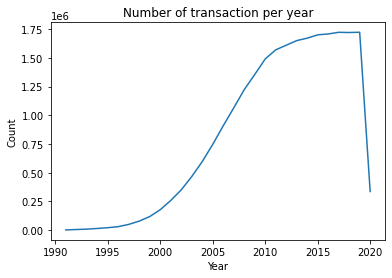

In [20]:
tmp = df.groupby(by=["Year"]).User.count()

plt.plot(tmp.index,tmp.values, label='count')
plt.title("Number of transaction per year")
plt.xlabel("Year")
plt.ylabel("Count")
tmp

1991      3
1992      2
1993      5
1994      8
1995      7
1996     17
1997     27
1998     38
1999     55
2000     61
2001     97
2002    112
2003    118
2004    138
2005    139
2006    140
2007    139
2008    131
2009     97
2010     89
2011     48
2012     26
2013     22
2014     19
2015     23
2016     15
2017     14
2018     16
2019     51
2020    343
Name: Year, dtype: int64

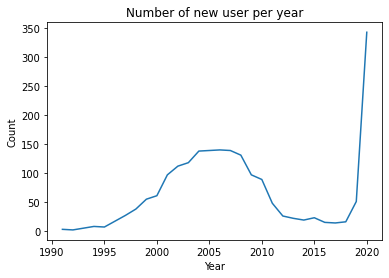

In [21]:
# Number of new users per Year
tmp = df.groupby(by='User').Year.min().value_counts().sort_index()

plt.plot(tmp.index,tmp.values, label='count')
plt.title("Number of new user per year")
plt.xlabel("Year")
plt.ylabel("Count")

tmp

In [22]:
tmp1=df.groupby(by='User').Year.min().value_counts().sort_index()
tmp2=df.groupby(by='Year').Fraud.sum().sort_index()
tmp3=df.groupby(by=["Year"]).User.count()
tmp = pd.DataFrame()
tmp['n_new_user'] = tmp1
tmp['n_fraud'] = tmp2
tmp['n_transaction'] = tmp3

In [23]:
tmp = tmp/tmp.max()

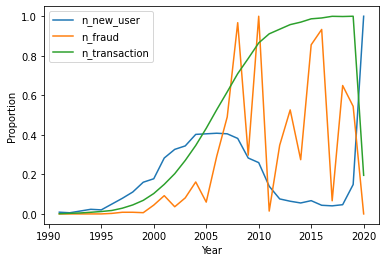

In [24]:
plt.plot(tmp.index,tmp.n_new_user.values, label='n_new_user')
plt.plot(tmp.index,tmp.n_fraud.values, label='n_fraud')
plt.plot(tmp.index,tmp.n_transaction.values, label='n_transaction')
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend();

* Here is data which take place since 1991 up to 2020
* Number of users in dataset increase to 2020 year. Last year is not full in data term
* More transaction - more fraud (Your Capitan :D)
* Since 2005 there is lot of fraud in data
* If number of new users drop - number of fraud drops also. Probably some people use face accounts to retrieve benefits

In [25]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,Zip,MCC,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff
0,791,1,1991,1,2,07:10,68.000000,Swipe Transaction,2027553650310142703,Burke,...,22015.0,5541,Empty,0,1991-01-02 07:10:00,2,7,10,0,0
1,791,1,1991,1,2,07:17,-68.000000,Swipe Transaction,2027553650310142703,Burke,...,22015.0,5541,Empty,0,1991-01-02 07:17:00,2,7,17,1,420
2,791,1,1991,1,2,07:21,113.620003,Swipe Transaction,2027553650310142703,Burke,...,22015.0,5541,Empty,0,1991-01-02 07:21:00,2,7,21,0,240
3,791,1,1991,1,2,17:30,114.730003,Swipe Transaction,-7269691894846892021,Burke,...,22015.0,5411,Empty,0,1991-01-02 17:30:00,2,17,30,0,36540
4,791,1,1991,1,3,09:03,251.710007,Swipe Transaction,-3693650930986299431,Burke,...,22015.0,4814,Empty,0,1991-01-03 09:03:00,3,9,3,0,55980


#### Month

In [26]:
df.groupby(by='Month').Fraud.sum()

Month
1     2302.0
2     2320.0
3     2608.0
4     2430.0
5     2481.0
6     2166.0
7     2332.0
8     2721.0
9     2373.0
10    2666.0
11    2635.0
12    2723.0
Name: Fraud, dtype: float64

In [27]:
df["Year_month"]=df.Year.astype(np.float32)*100+df.Month

Text(0, 0.5, 'Fraud')

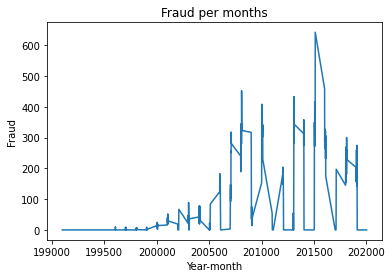

In [28]:
tmp = df.groupby(by='Year_month').Fraud.sum().sort_index()
plt.plot(tmp.index, tmp);
plt.title("Fraud per months")
plt.xlabel("Year-month")
plt.ylabel("Fraud")

* Here is the same level of fraud during months
* In trend here is a lot of seasonality

#### Day and DoW

<AxesSubplot:xlabel='Day'>

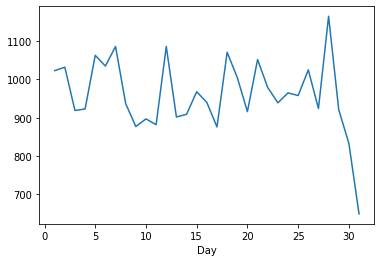

In [29]:
df.groupby(by='Day').Fraud.sum().plot()

<AxesSubplot:xlabel='Dow'>

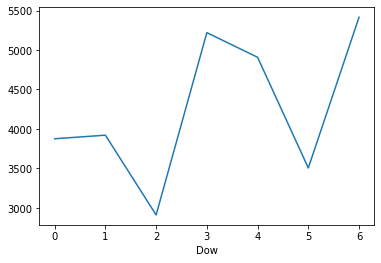

In [30]:
df.groupby(by='Dow').Fraud.sum().plot()

* Much more fraud happens on Tursday, Friday and Sunday.
* In data here is also some seasonality during the month. Probably it is day's periodic

#### Amount

In [31]:
df[df.Fraud==1].Amount.mean(), df[df.Fraud==1].Amount.median()

(108.590866, 71.02)

In [32]:
df[df.Fraud==1].Amount.quantile(0.025) ,df[df.Fraud==1].Amount.quantile(0.975)

(-212.0, 500.0)

In [33]:
df[df.Fraud==0].Amount.mean(), df[df.Fraud==0].Amount.median()

(43.554657, 30.11)

In [34]:
df[df.Fraud==0].Amount.quantile(0.025) ,df[df.Fraud==0].Amount.quantile(0.975)

(-79.0, 198.27000427246094)

In [35]:
bins = pd.IntervalIndex.from_tuples([(-np.inf, -213), (-213, -80), (-80, -1), (-1, 198), (198, 500), (500, np.inf)])
df["Amount_cat"] = pd.cut(df.Amount, bins=bins, labels=False)
df["Amount_cat"] = LabelEncoder().fit_transform(df["Amount_cat"])

<AxesSubplot:xlabel='Amount_cat', ylabel='count'>

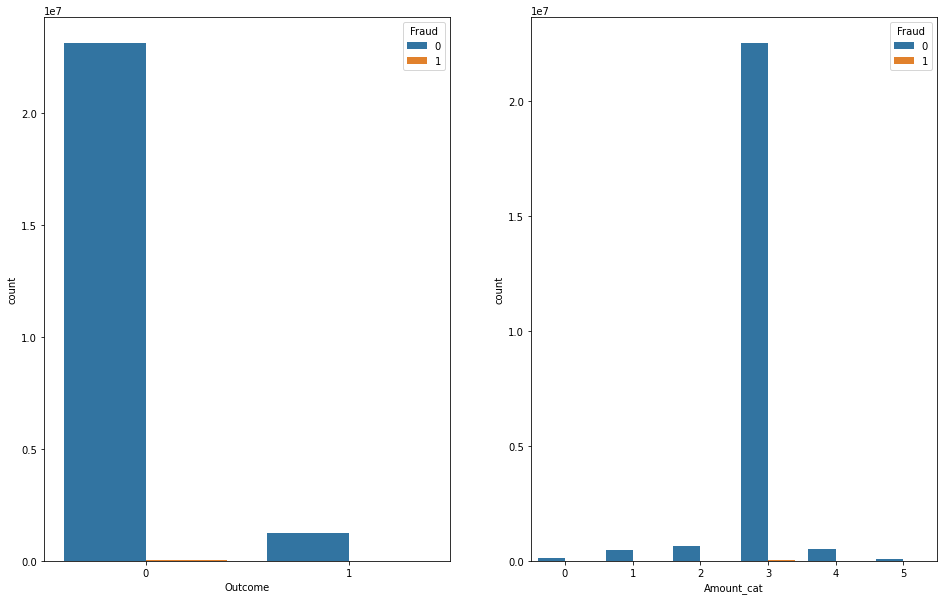

In [36]:
fig, ax = plt.subplots(1,2,figsize=(16,10))
sns.countplot(data=df, x='Outcome', hue='Fraud', ax=ax[0])
sns.countplot(data=df, x='Amount_cat', hue='Fraud', ax=ax[1])

In [37]:
pd.crosstab(df.Amount_cat, df.Fraud)

Fraud,0,1
Amount_cat,,
0,106859,743
1,492209,350
2,644328,32
3,22503272,23545
4,531943,4348
5,78532,739


In [38]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff,Year_month,Amount_cat
0,791,1,1991,1,2,07:10,68.000000,Swipe Transaction,2027553650310142703,Burke,...,Empty,0,1991-01-02 07:10:00,2,7,10,0,0,199101.0,3
1,791,1,1991,1,2,07:17,-68.000000,Swipe Transaction,2027553650310142703,Burke,...,Empty,0,1991-01-02 07:17:00,2,7,17,1,420,199101.0,2
2,791,1,1991,1,2,07:21,113.620003,Swipe Transaction,2027553650310142703,Burke,...,Empty,0,1991-01-02 07:21:00,2,7,21,0,240,199101.0,3
3,791,1,1991,1,2,17:30,114.730003,Swipe Transaction,-7269691894846892021,Burke,...,Empty,0,1991-01-02 17:30:00,2,17,30,0,36540,199101.0,3
4,791,1,1991,1,3,09:03,251.710007,Swipe Transaction,-3693650930986299431,Burke,...,Empty,0,1991-01-03 09:03:00,3,9,3,0,55980,199101.0,4


#### Use Chip

<AxesSubplot:xlabel='Use Chip', ylabel='count'>

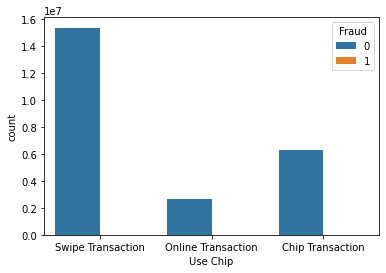

In [39]:
sns.countplot(data=df, x='Use Chip', hue='Fraud')

In [40]:
df["Use Chip"] = LabelEncoder().fit_transform(df["Use Chip"]).astype(np.int8)

In [41]:
columns_to_drop = []
columns_to_drop.append("Year")
columns_to_drop.append("Time")
columns_to_drop.append("Amount")
columns_to_drop.append("Year_month")

In [42]:
df.drop(columns=columns_to_drop, inplace=True)

In [43]:
df[df["Merchant State"].isnull()]["Merchant City"].unique()

array([' ONLINE'], dtype=object)

In [44]:
df[df["Merchant City"]!=" ONLINE"]["Merchant State"].isnull().sum()

0

In [45]:
df["Merchant State"].fillna("ONLINE", inplace=True)

In [46]:
df.head()

,User,Card,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff,Amount_cat
0,791,1,1,2,2,2027553650310142703,Burke,VA,22015.0,5541,Empty,0,1991-01-02 07:10:00,2,7,10,0,0,3
1,791,1,1,2,2,2027553650310142703,Burke,VA,22015.0,5541,Empty,0,1991-01-02 07:17:00,2,7,17,1,420,2
2,791,1,1,2,2,2027553650310142703,Burke,VA,22015.0,5541,Empty,0,1991-01-02 07:21:00,2,7,21,0,240,3
3,791,1,1,2,2,-7269691894846892021,Burke,VA,22015.0,5411,Empty,0,1991-01-02 17:30:00,2,17,30,0,36540,3
4,791,1,1,3,2,-3693650930986299431,Burke,VA,22015.0,4814,Empty,0,1991-01-03 09:03:00,3,9,3,0,55980,4


#### Errrors

In [47]:
df.Errors.unique()

array(['Empty', 'Insufficient Balance,', 'Technical Glitch,',
       'Bad Zipcode,', 'Bad PIN,', 'Bad PIN,Insufficient Balance,',
       'Bad Zipcode,Technical Glitch,', 'Bad Card Number,',
       'Bad Expiration,', 'Bad CVV,',
       'Insufficient Balance,Technical Glitch,',
       'Bad Card Number,Technical Glitch,', 'Bad PIN,Technical Glitch,',
       'Bad Card Number,Bad Expiration,', 'Bad CVV,Technical Glitch,',
       'Bad Card Number,Insufficient Balance,', 'Bad Expiration,Bad CVV,',
       'Bad Expiration,Insufficient Balance,',
       'Bad Zipcode,Insufficient Balance,',
       'Bad CVV,Insufficient Balance,',
       'Bad Expiration,Technical Glitch,', 'Bad Card Number,Bad CVV,',
       'Bad Card Number,Bad Expiration,Technical Glitch,',
       'Bad Card Number,Bad Expiration,Insufficient Balance,'],
      dtype=object)

In [48]:
tmp = pd.crosstab(df.Errors, df.Fraud)
tmp

Fraud,0,1
Errors,,
"Bad CVV,",10460,280
"Bad CVV,Insufficient Balance,",85,4
"Bad CVV,Technical Glitch,",20,1
"Bad Card Number,",13216,105
"Bad Card Number,Bad CVV,",60,0
"Bad Card Number,Bad Expiration,",54,0
"Bad Card Number,Bad Expiration,Insufficient Balance,",2,0
"Bad Card Number,Bad Expiration,Technical Glitch,",1,0
"Bad Card Number,Insufficient Balance,",120,2


In [49]:
indexes_with_low_proba = []
for indx in tmp.index:
    if tmp.loc[indx,:].sum() < 2500:
        indexes_with_low_proba.append(indx)

In [50]:
df.loc[df.Errors.isin(indexes_with_low_proba), "Errors"] = "Rare"

In [51]:
tmp = pd.crosstab(df.Errors, df.Fraud)
tmp

Fraud,0,1
Errors,,
"Bad CVV,",10460,280
"Bad Card Number,",13216,105
"Bad Expiration,",10596,120
"Bad PIN,",58616,302
Empty,23969998,28471
"Insufficient Balance,",242387,396
Rare,3776,20
"Technical Glitch,",48094,63


In [52]:
df.Errors = LabelEncoder().fit_transform(df.Errors).astype(np.int8)

#### Time_diff

<AxesSubplot:>

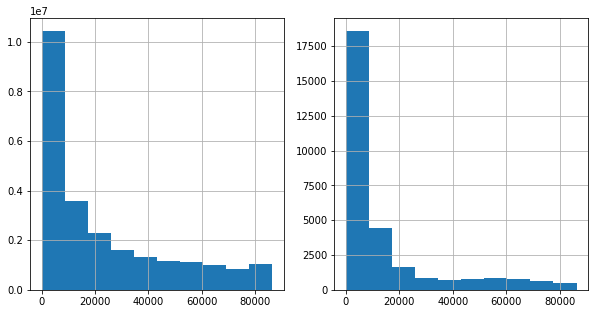

In [53]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
df[df.Fraud==0].Time_diff.hist(ax=ax[0])
df[df.Fraud==1].Time_diff.hist(ax=ax[1])

#### 

In [54]:
df.head()

,User,Card,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff,Amount_cat
0,791,1,1,2,2,2027553650310142703,Burke,VA,22015.0,5541,4,0,1991-01-02 07:10:00,2,7,10,0,0,3
1,791,1,1,2,2,2027553650310142703,Burke,VA,22015.0,5541,4,0,1991-01-02 07:17:00,2,7,17,1,420,2
2,791,1,1,2,2,2027553650310142703,Burke,VA,22015.0,5541,4,0,1991-01-02 07:21:00,2,7,21,0,240,3
3,791,1,1,2,2,-7269691894846892021,Burke,VA,22015.0,5411,4,0,1991-01-02 17:30:00,2,17,30,0,36540,3
4,791,1,1,3,2,-3693650930986299431,Burke,VA,22015.0,4814,4,0,1991-01-03 09:03:00,3,9,3,0,55980,4


#### Merchant name

In [55]:
len(df["Merchant Name"].unique())

100343

In [56]:
df["is_diff_merchant"] = df.groupby('User')["Merchant Name"].diff()
df.is_diff_merchant.fillna(0, inplace=True)
df.loc[df.is_diff_merchant!=0, 'is_diff_merchant']=1
df.is_diff_merchant = df.is_diff_merchant.astype(np.int8)
df.drop(columns="Merchant Name", inplace=True)

In [57]:
df.head()

,User,Card,Month,Day,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff,Amount_cat,is_diff_merchant
0,791,1,1,2,2,Burke,VA,22015.0,5541,4,0,1991-01-02 07:10:00,2,7,10,0,0,3,0
1,791,1,1,2,2,Burke,VA,22015.0,5541,4,0,1991-01-02 07:17:00,2,7,17,1,420,2,0
2,791,1,1,2,2,Burke,VA,22015.0,5541,4,0,1991-01-02 07:21:00,2,7,21,0,240,3,0
3,791,1,1,2,2,Burke,VA,22015.0,5411,4,0,1991-01-02 17:30:00,2,17,30,0,36540,3,1
4,791,1,1,3,2,Burke,VA,22015.0,4814,4,0,1991-01-03 09:03:00,3,9,3,0,55980,4,1


#### MCC

In [58]:
tmp = pd.crosstab(df.MCC, df.Fraud)
tmp["portion"]=tmp[1]/tmp[0]
tmp

Fraud,0,1,portion
MCC,,,
1711,6065,0,0.000000
3000,5724,74,0.012928
3001,5742,62,0.010798
3005,686,43,0.062682
3006,643,59,0.091757
...,...,...,...
8062,6715,23,0.003425
8099,27594,21,0.000761
8111,13236,0,0.000000


In [59]:
seldom_indexes = []
for indx in tmp.index:
    if tmp.loc[indx,"portion"] < 0.05:
        seldom_indexes.append(indx)

In [60]:
df.loc[df.MCC.isin(seldom_indexes), "MCC"] = 0

In [61]:
pd.crosstab(df.MCC, df.Fraud)

Fraud,0,1
MCC,,
0,24315332,26388
3005,686,43
3006,643,59
3007,625,41
3008,664,50
3009,696,43
3075,626,40
3144,579,53
4411,317,317


In [62]:
df.MCC = LabelEncoder().fit_transform(df["MCC"]).astype(np.int8)

In [63]:
df.head()

,User,Card,Month,Day,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff,Amount_cat,is_diff_merchant
0,791,1,1,2,2,Burke,VA,22015.0,0,4,0,1991-01-02 07:10:00,2,7,10,0,0,3,0
1,791,1,1,2,2,Burke,VA,22015.0,0,4,0,1991-01-02 07:17:00,2,7,17,1,420,2,0
2,791,1,1,2,2,Burke,VA,22015.0,0,4,0,1991-01-02 07:21:00,2,7,21,0,240,3,0
3,791,1,1,2,2,Burke,VA,22015.0,0,4,0,1991-01-02 17:30:00,2,17,30,0,36540,3,1
4,791,1,1,3,2,Burke,VA,22015.0,0,4,0,1991-01-03 09:03:00,3,9,3,0,55980,4,1


#### Merchant City and State

In [64]:
df["Merchant State"].unique()

array(['VA', 'CA', 'NJ', 'NY', 'PA', 'FL', 'Mexico', 'MO', 'OH', 'NV',
       'HI', 'South Korea', 'MA', 'TX', 'WA', 'AK', 'GA', 'IL', 'OR',
       'United Arab Emirates', 'Jamaica', 'CO', 'NC', 'VT', 'Japan', 'SD',
       'IN', 'ND', 'LA', 'Spain', 'CT', 'AZ', 'MI', 'RI', 'MN', 'NH',
       'MS', 'IA', 'MT', 'NM', 'AR', 'DE', 'Netherlands', 'AL', 'MD',
       'SC', 'KY', 'Sweden', 'Germany', 'China', 'UT', 'Israel', 'WV',
       'ONLINE', 'France', 'DC', 'KS', 'Italy', 'WI', 'ID', 'TN',
       'Philippines', 'Canada', 'Turkey', 'OK', 'ME', 'Hong Kong',
       'Norway', 'Fiji', 'Dominican Republic', 'Colombia', 'Austria',
       'United Kingdom', 'WY', 'Aruba', 'New Zealand', 'NE', 'Algeria',
       'Portugal', 'Bangladesh', 'Brazil', 'India', 'Peru', 'AA',
       'The Bahamas', 'Greece', 'Ireland', 'Switzerland', 'South Africa',
       'Australia', 'Serbia', 'Singapore', 'Costa Rica', 'Thailand',
       'Iraq', 'Saudi Arabia', 'Taiwan', 'Argentina', 'Vietnam',
       'Croatia', 'Pakis

In [65]:
len(df["Merchant City"].unique())

13429

In [66]:
tmp = df.groupby(by='User')["Merchant City"].agg(lambda x:x.value_counts().index[0])
tmp

User
0            La Verne
1         Little Neck
2              ONLINE
3            New York
4       San Francisco
            ...      
1995      Garden City
1996     Independence
1997        Elizabeth
1998        Camp Hill
1999        Merrimack
Name: Merchant City, Length: 2000, dtype: object

In [67]:
%%time
for user in tqdm(df.User.unique()):
    df.loc[df.User==user, 'Merchant City'] = (df.loc[df.User==user, 'Merchant City'] == tmp[user]).astype(np.int8)

CPU times: user 7min 5s, sys: 4min 13s, total: 11min 19s
Wall time: 11min 19s


In [68]:
df.head()

,User,Card,Month,Day,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff,Amount_cat,is_diff_merchant
0,791,1,1,2,2,1,VA,22015.0,0,4,0,1991-01-02 07:10:00,2,7,10,0,0,3,0
1,791,1,1,2,2,1,VA,22015.0,0,4,0,1991-01-02 07:17:00,2,7,17,1,420,2,0
2,791,1,1,2,2,1,VA,22015.0,0,4,0,1991-01-02 07:21:00,2,7,21,0,240,3,0
3,791,1,1,2,2,1,VA,22015.0,0,4,0,1991-01-02 17:30:00,2,17,30,0,36540,3,1
4,791,1,1,3,2,1,VA,22015.0,0,4,0,1991-01-03 09:03:00,3,9,3,0,55980,4,1


In [69]:
tmp = df.groupby(by='User')["Merchant State"].agg(lambda x:x.value_counts().index[0])
tmp

User
0       CA
1       NY
2       CA
3       NY
4       CA
        ..
1995    NY
1996    KY
1997    NJ
1998    PA
1999    NH
Name: Merchant State, Length: 2000, dtype: object

In [71]:
%%time
for user in tqdm(df.User.unique()):
    df.loc[df.User==user, 'Merchant State'] = (df.loc[df.User==user, 'Merchant State'] == tmp[user]).astype(np.int8)

CPU times: user 7min 24s, sys: 4min 23s, total: 11min 48s
Wall time: 11min 48s


In [72]:
df.head()

,User,Card,Month,Day,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors,Fraud,Date,Dow,Hour,Minute,Outcome,Time_diff,Amount_cat,is_diff_merchant
0,791,1,1,2,2,1,1,22015.0,0,4,0,1991-01-02 07:10:00,2,7,10,0,0,3,0
1,791,1,1,2,2,1,1,22015.0,0,4,0,1991-01-02 07:17:00,2,7,17,1,420,2,0
2,791,1,1,2,2,1,1,22015.0,0,4,0,1991-01-02 07:21:00,2,7,21,0,240,3,0
3,791,1,1,2,2,1,1,22015.0,0,4,0,1991-01-02 17:30:00,2,17,30,0,36540,3,1
4,791,1,1,3,2,1,1,22015.0,0,4,0,1991-01-03 09:03:00,3,9,3,0,55980,4,1


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   User              int16         
 1   Card              int8          
 2   Month             int8          
 3   Day               int8          
 4   Use Chip          int8          
 5   Merchant City     object        
 6   Merchant State    object        
 7   Zip               float32       
 8   MCC               int8          
 9   Errors            int8          
 10  Fraud             int8          
 11  Date              datetime64[ns]
 12  Dow               int64         
 13  Hour              int8          
 14  Minute            int8          
 15  Outcome           int8          
 16  Time_diff         int64         
 17  Amount_cat        int64         
 18  is_diff_merchant  int8          
dtypes: datetime64[ns](1), float32(1), int16(1), int64(3), int8(11), object(2)
memory u

In [75]:
df.to_csv("data/data_after_eda.csv", index=False)